# 3.1 Baseline - Spacy

#### Data Loading e Pré-processamento

In [2]:
import nltk
import csv
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter
import itertools
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading dos datasets como dataframes

In [5]:
train_df = pd.read_csv("imdb_reviews_train.csv", encoding="utf-8")
test_df = pd.read_csv("imdb_reviews_test.csv", encoding="utf-8")
print(train_df.head(10))
print(test_df.head(10))

                                                text label
0  This is your typical cheerful and colorful MGM...   pos
1  As a another reviewer states Hanna's War is an...   pos
2  One of the best "Amitabh comeback" movies I li...   pos
3  Peter Sollett has created an endearing portrai...   pos
4  The film is not visually stunning in the conve...   pos
5  This is not Bela Lagosi's best movie, but it's...   pos
6  I happened to watch this movie by chance some ...   pos
7  So many consider The Black Cat as the best Kar...   pos
8  I saw this at a screening last night too. I wa...   pos
9  One of the best true crime movies ever made an...   pos
                                                text label
0  Logan Lerman & Dean Collins III of Jack & Bobb...   pos
1  I have seen this film on a Sunday evening and ...   pos
2  Two great stars and a legendary Director creat...   pos
3  I'm originally from Brazil... the sad thing ab...   pos
4  "Witchery" is a decent little Euro Trash horro...   p

Lowercase

In [6]:
# Converte todas as letras para minúsculas
train_lower = train_df['text'].apply(lambda x: x.lower())
# mesmo para o conjunto de teste
test_lower = test_df['text'].apply(lambda x: x.lower())
train_lower

,text
0,this is your typical cheerful and colorful mgm...
1,as a another reviewer states hanna's war is an...
2,"one of the best ""amitabh comeback"" movies i li..."
3,peter sollett has created an endearing portrai...
4,the film is not visually stunning in the conve...
...,...
21749,"in the third entry of the phantasm series, mik..."
21750,this movie still chills me to the bone thinkin...
21751,is this film a joke? is it a comedy? surely it...
21752,all of david prior's movies are terrible on al...


In [7]:
# Para baseline, apenas utlizamos as reviews com lowercase
train_lower = pd.DataFrame(train_lower)
train_lower['label'] = train_df['label']
test_lower = pd.DataFrame(test_lower)
test_lower['label'] = test_df['label']
print(train_lower.head(5))
print(test_lower.head(5))

                                                text label
0  this is your typical cheerful and colorful mgm...   pos
1  as a another reviewer states hanna's war is an...   pos
2  one of the best "amitabh comeback" movies i li...   pos
3  peter sollett has created an endearing portrai...   pos
4  the film is not visually stunning in the conve...   pos
                                                text label
0  logan lerman & dean collins iii of jack & bobb...   pos
1  i have seen this film on a sunday evening and ...   pos
2  two great stars and a legendary director creat...   pos
3  i'm originally from brazil... the sad thing ab...   pos
4  "witchery" is a decent little euro trash horro...   pos


#### Modelo

Estrutura do modelo

In [8]:
import spacy
from spacy.training.example import Example
from spacy.util import minibatch, compounding
import random

In [9]:
train_data = []

for i, row in train_lower.iterrows():
    label = row['label']

    text_str = train_lower['text'][i]
    cats = {"pos": 1.0 if label == "pos" else 0.0,
            "neg": 1.0 if label == "neg" else 0.0}

    train_data.append((text_str, {"cats": cats}))

# mesmo para o conjunto de teste
test_data = []

for i, row in test_lower.iterrows():
    label = row['label']

    text_str = test_lower['text'][i]
    cats = {"pos": 1.0 if label == "pos" else 0.0,
            "neg": 1.0 if label == "neg" else 0.0}

    test_data.append((text_str, {"cats": cats}))


In [10]:
train_data[:5]
test_data[:5]

[('logan lerman & dean collins iii of jack & bobby fame provide a nice touch of familiarity as friends in this even if not maybe as close as they may be on jack & bobby but the expressions of young students taking their stand for a good cause is very well expressed in this movie.logan lerman may be seemingly typecast in roles of being "different" as thusly seen from here as is seen in this as well as in jack and bobby.the movie also opens up with a very nice tune coined as a lost 45 "and i\'m wondering where the lions are?"a song which i\'d always heard on the speaker @ my old job of christmastreeshops and got it played on my local radio show of the lost45s hosted by barry scott but the last time of which i suggested this with this movie as it\'s dedication but the dedication was left out.environmentalist demonstration is well expressed in this movie too for the protection of the ground owls as seen in this movie too.what a hoot too this movie is.hoot,sogive a hoot in the tradition of 

In [11]:
# Criar pipeline vazia
nlp = spacy.blank("en")

# Adicionar TextCategorizer
text_cat = nlp.add_pipe("textcat", last=True)

# Adicionar rótulos
text_cat.add_label("pos")
text_cat.add_label("neg")

1

In [12]:
# optimizador inicial dos pesos
optimizer = nlp.begin_training()

for i in range(10):  # número de épocas
    random.shuffle(train_data) # shuffle dos dados de treino
    losses = {}
    batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.5)) # tamanho dos batches, começa em 4 e aumenta até 32 (aumenta 1.5x a cada iteração)
    for batch in batches:
        examples = []
        for text, annotations in batch:
            doc = nlp.make_doc(text) # doc cria uam representação do texto que vai permitir para treino (lemmatização, POS, ...)
            examples.append(Example.from_dict(doc, annotations)) # cria um exemplo a partir do doc e das labels
        nlp.update(examples, sgd=optimizer, losses=losses) # o verdadeiro treino, atualiza os pesos do modelo
    print(f"Losses at iteration {i}: {losses}")


Losses at iteration 0: {'textcat': 79.51752169057727}
Losses at iteration 1: {'textcat': 42.942523371079005}
Losses at iteration 2: {'textcat': 27.253294983063824}
Losses at iteration 3: {'textcat': 19.03417518121978}
Losses at iteration 4: {'textcat': 14.593196318318405}
Losses at iteration 5: {'textcat': 11.029494218682036}
Losses at iteration 6: {'textcat': 8.552255361551971}
Losses at iteration 7: {'textcat': 8.019092129383784}
Losses at iteration 8: {'textcat': 6.4638569393405945}
Losses at iteration 9: {'textcat': 5.993967101085694}


In [15]:
doc = nlp(test_data[0][0]) # exemplo
doc.cats  # Probabilidades para cada categoria (neg e pos) do texto

{'pos': 0.99922776222229, 'neg': 0.0007722379523329437}

Resultados

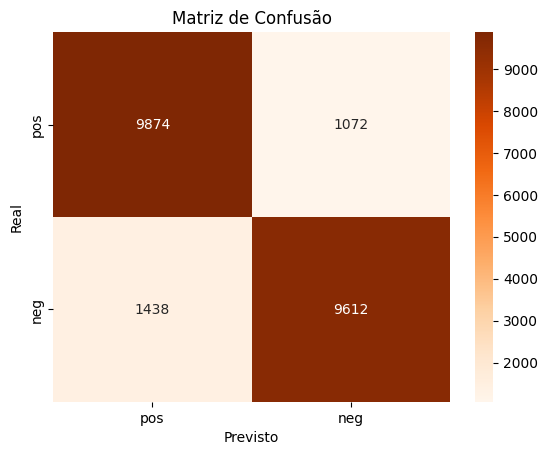

              precision    recall  f1-score   support

         pos       0.90      0.87      0.88     11050
         neg       0.87      0.90      0.89     10946

    accuracy                           0.89     21996
   macro avg       0.89      0.89      0.89     21996
weighted avg       0.89      0.89      0.89     21996



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = []
predicted_labels = []

# Iterate over each example in the test_data
for text, annotations in test_data:
    doc = nlp(text)  # Process the text with spaCy model

    # Ensure there is a valid output in doc.cats
    if not doc.cats:
        print(f"Empty prediction for text: {text}")
        continue # Skip if no prediction was made

    # Get the predicted category (label) with the highest probability
    predicted = max(doc.cats, key=doc.cats.get)
    # Determine the true label from annotations
    actual = "pos" if annotations["cats"]["pos"] > annotations["cats"]["neg"] else "neg"

    predicted_labels.append(predicted)
    true_labels.append(actual)

# Matriz de confusão
cm = confusion_matrix(true_labels, predicted_labels, labels=["pos", "neg"])

# Mostrar matriz com seaborn
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["pos", "neg"], yticklabels=["pos", "neg"], cmap="Oranges")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Também podes imprimir relatório completo:
print(classification_report(true_labels, predicted_labels, target_names=["pos", "neg"]))
